In [1]:
import nltk
from nltk import FreqDist
import re
import emoji
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string #load punctuation charachers
from matplotlib import pyplot
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


# Loading Data

In [2]:
#load data
train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
test_df  = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')

# Data Exploration

In [3]:
#see data configuration
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [5]:
cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for c in cols:
    print(c,'column values',train_df[c].unique())
    print('statistics')
    print(train_df[c].value_counts())
    print('---------------------------------')

toxic column values [0 1]
statistics
0    144277
1     15294
Name: toxic, dtype: int64
---------------------------------
severe_toxic column values [0 1]
statistics
0    157976
1      1595
Name: severe_toxic, dtype: int64
---------------------------------
obscene column values [0 1]
statistics
0    151122
1      8449
Name: obscene, dtype: int64
---------------------------------
threat column values [0 1]
statistics
0    159093
1       478
Name: threat, dtype: int64
---------------------------------
insult column values [0 1]
statistics
0    151694
1      7877
Name: insult, dtype: int64
---------------------------------
identity_hate column values [0 1]
statistics
0    158166
1      1405
Name: identity_hate, dtype: int64
---------------------------------


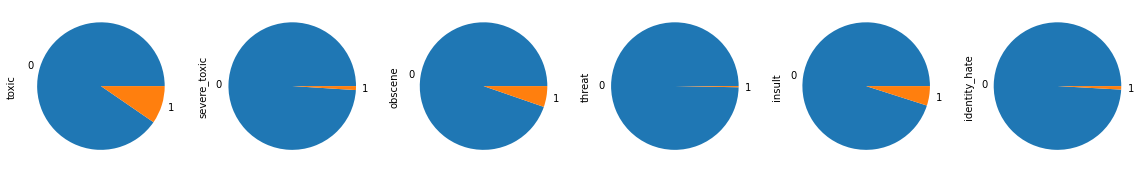

In [6]:
#EDA
_,ax = pyplot.subplots(1,6,figsize=(20,20))
for i,c in  enumerate(cols):
    train_df[c].value_counts().plot(kind='pie',ax=ax[i])

# Preprocessing

In [7]:
import textblob
from textblob import Word

In [8]:
#remove stopwords and punctuations
stopwrds = set(stopwords.words('english'))
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    #translate emojis 
    sentence = emoji.demojize(sen)
    #Remove URLs
    sentence = re.sub(r"http:\S+",'',sentence)
    #Remove \n
    sentence = re.sub(r"\n",' ',sentence)
    #check stop words, alpha words and correct spelling
    sentence = ' '.join([x for x in nltk.word_tokenize(sentence) if x not in stopwrds and x.isalpha()])
    # Removing html tags
    sentence = remove_tags(sentence)
    # Remove punctuations 
    sentence = re.sub(r'['+string.punctuation+']','',sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence.strip()

In [9]:
#Extract hashtags
train_df["hashtags"]=train_df["comment_text"].apply(lambda x:re.findall(r"#(\w+)",x.lower()))
test_df["hashtags"]=test_df["comment_text"].apply(lambda x:re.findall(r"#(\w+)",x.lower()))

In [10]:
#preprocess data
train_df['cleaned_text'] = train_df['comment_text'].apply(lambda x: preprocess_text(x.lower()))

In [11]:
test_df['cleaned_text'] = test_df['comment_text'].apply(lambda x: preprocess_text(x.lower()))

In [12]:
train_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,hashtags,cleaned_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,[],explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,[],matches background colour seemingly stuck than...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,[],hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,[transport],ca make real suggestions improvement wondered ...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,[],sir hero chance remember page


# Explanatory Analysis using Word Cloud

In [13]:
def plot_word_cloud(pos_lst,neg_lst):
    _,ax = pyplot.subplots(1,2,figsize=(50,50))
    wordcloud = WordCloud(width = 400, height = 400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(pos_lst)
 
    ax[0].imshow(wordcloud)
    ax[0].axis("off")
    
    wordcloud = WordCloud(width = 400, height = 400,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(neg_lst)
 
    ax[1].imshow(wordcloud)
    ax[1].axis("off")
    pyplot.show()

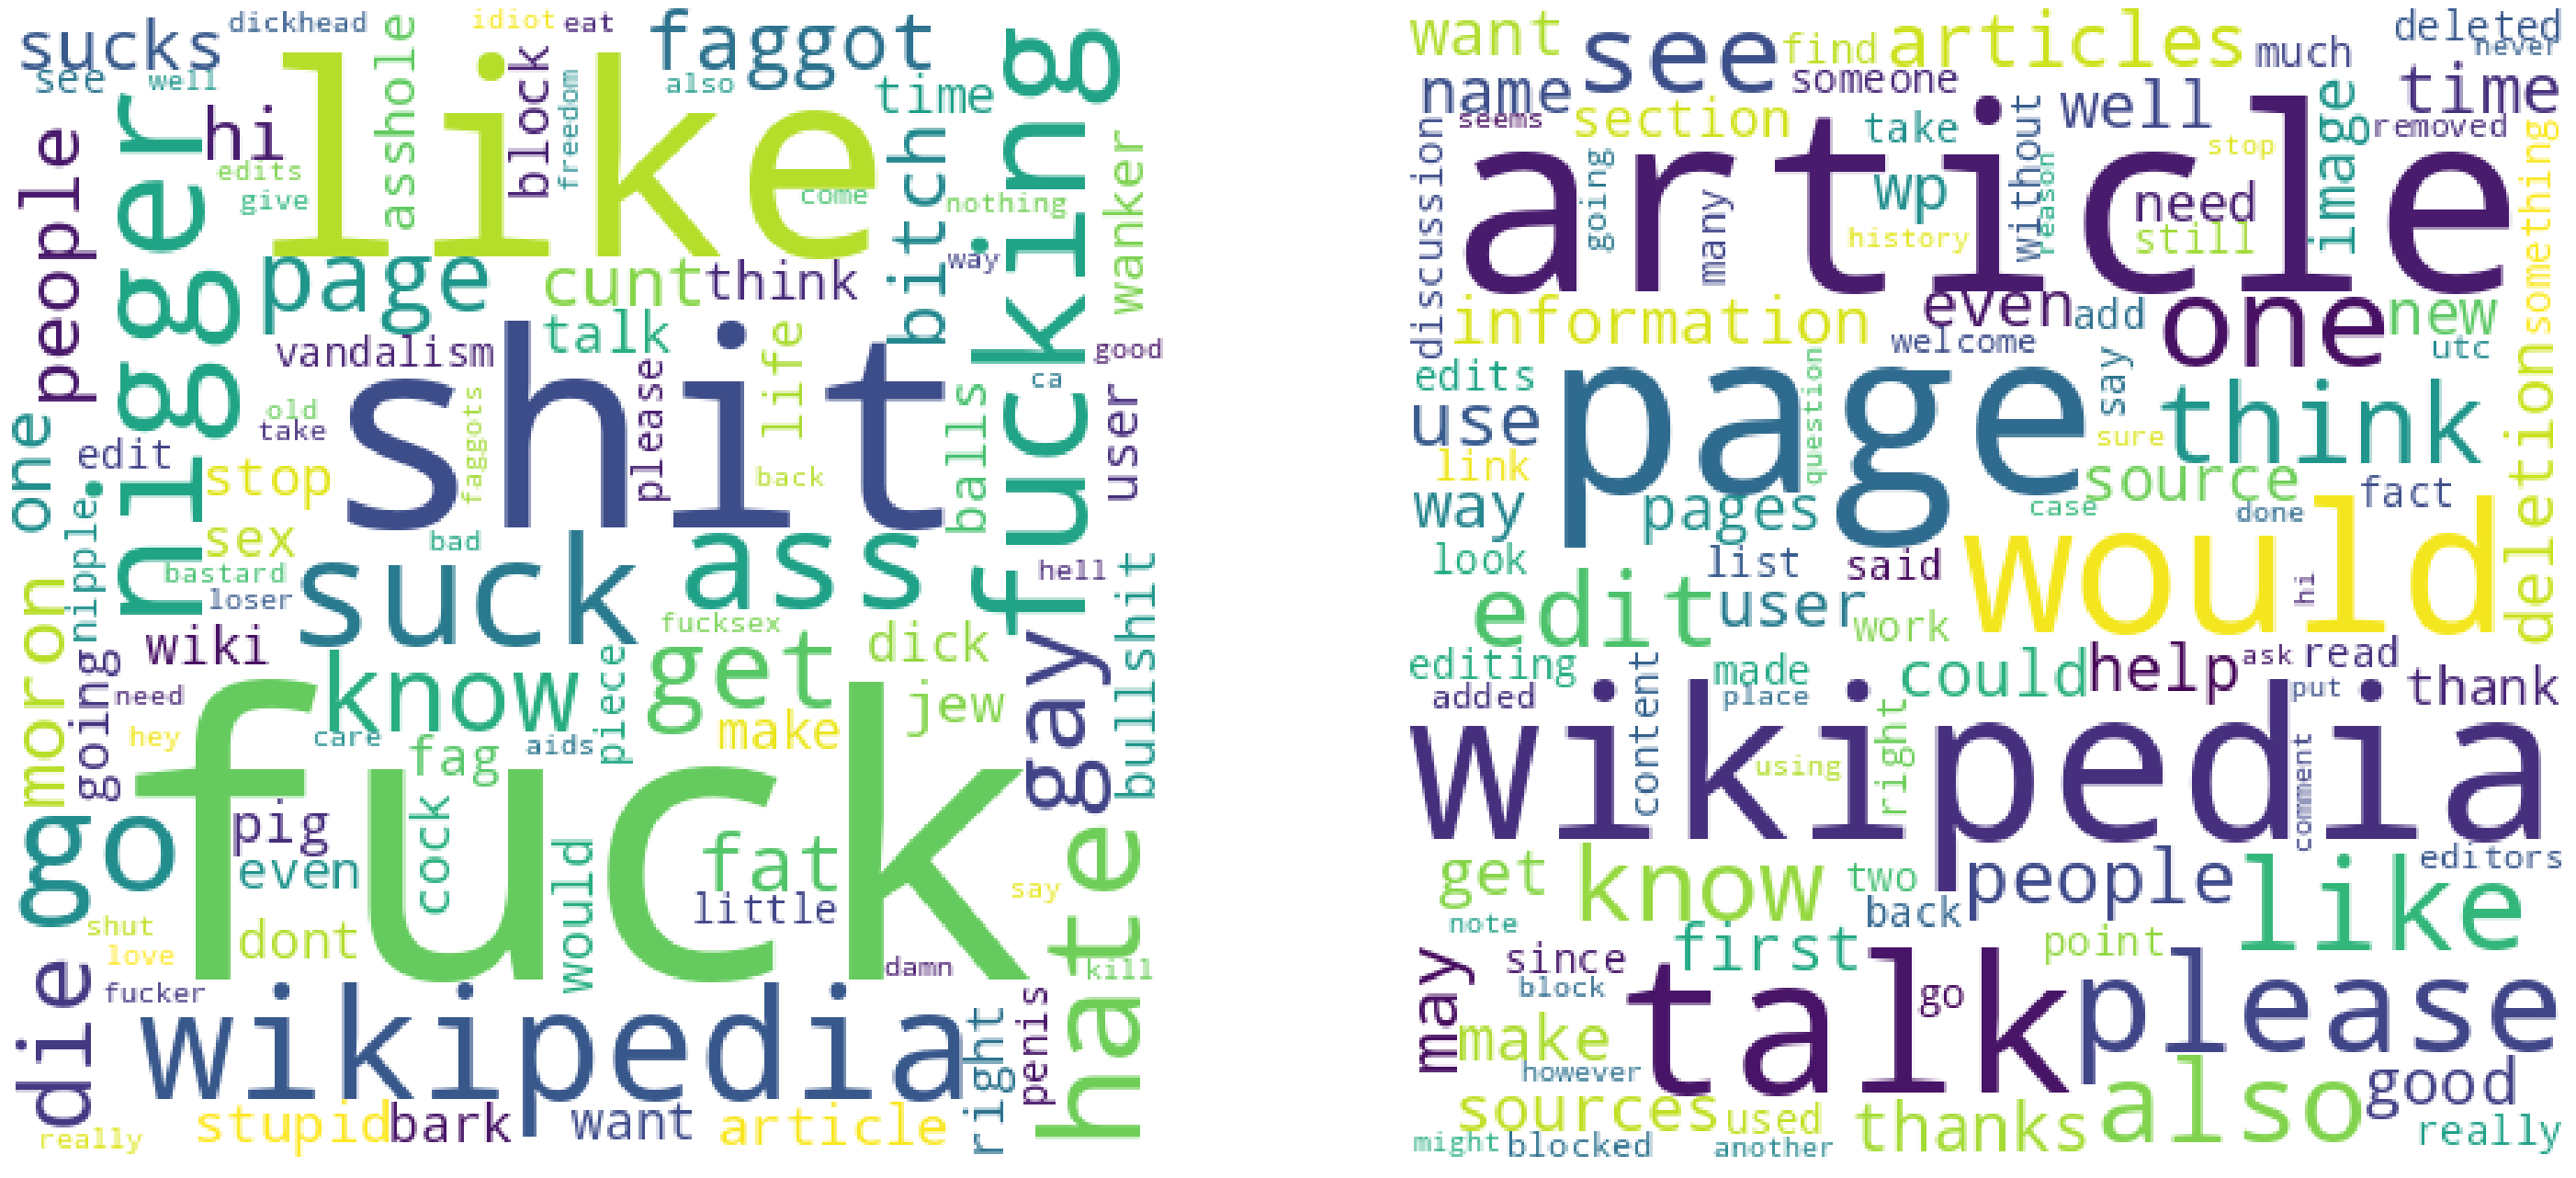

In [14]:
plot_word_cloud(FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["toxic"]==1]["cleaned_text"]))),
               FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["toxic"]==0]["cleaned_text"]))))

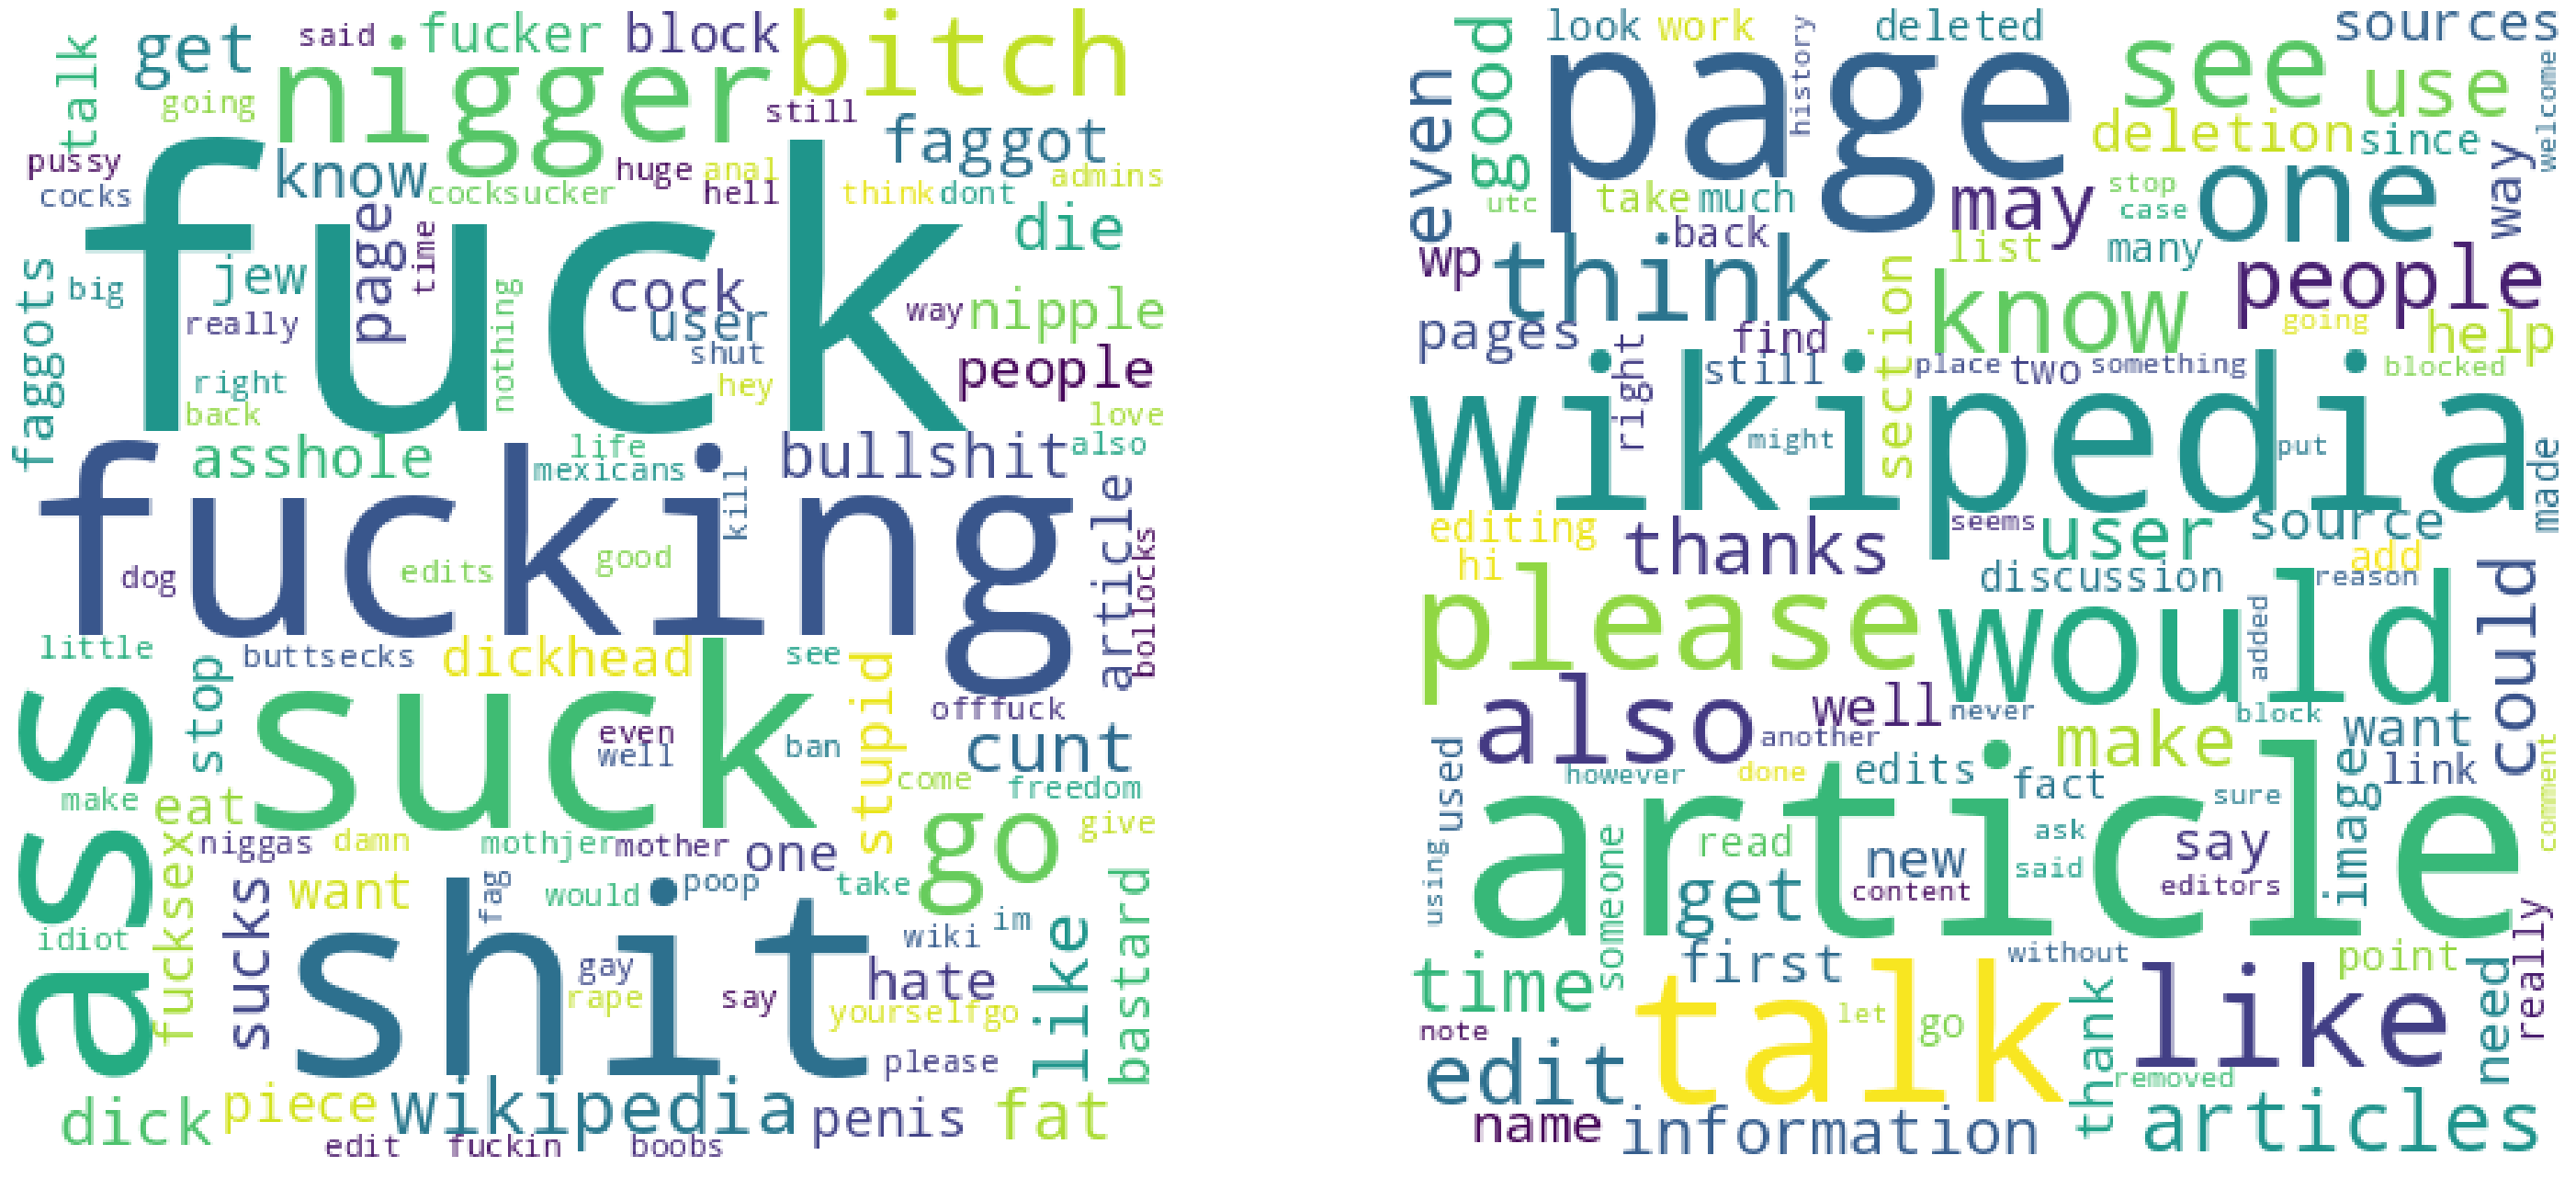

In [15]:
plot_word_cloud(FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["obscene"]==1]["cleaned_text"]))),
               FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["obscene"]==0]["cleaned_text"]))))

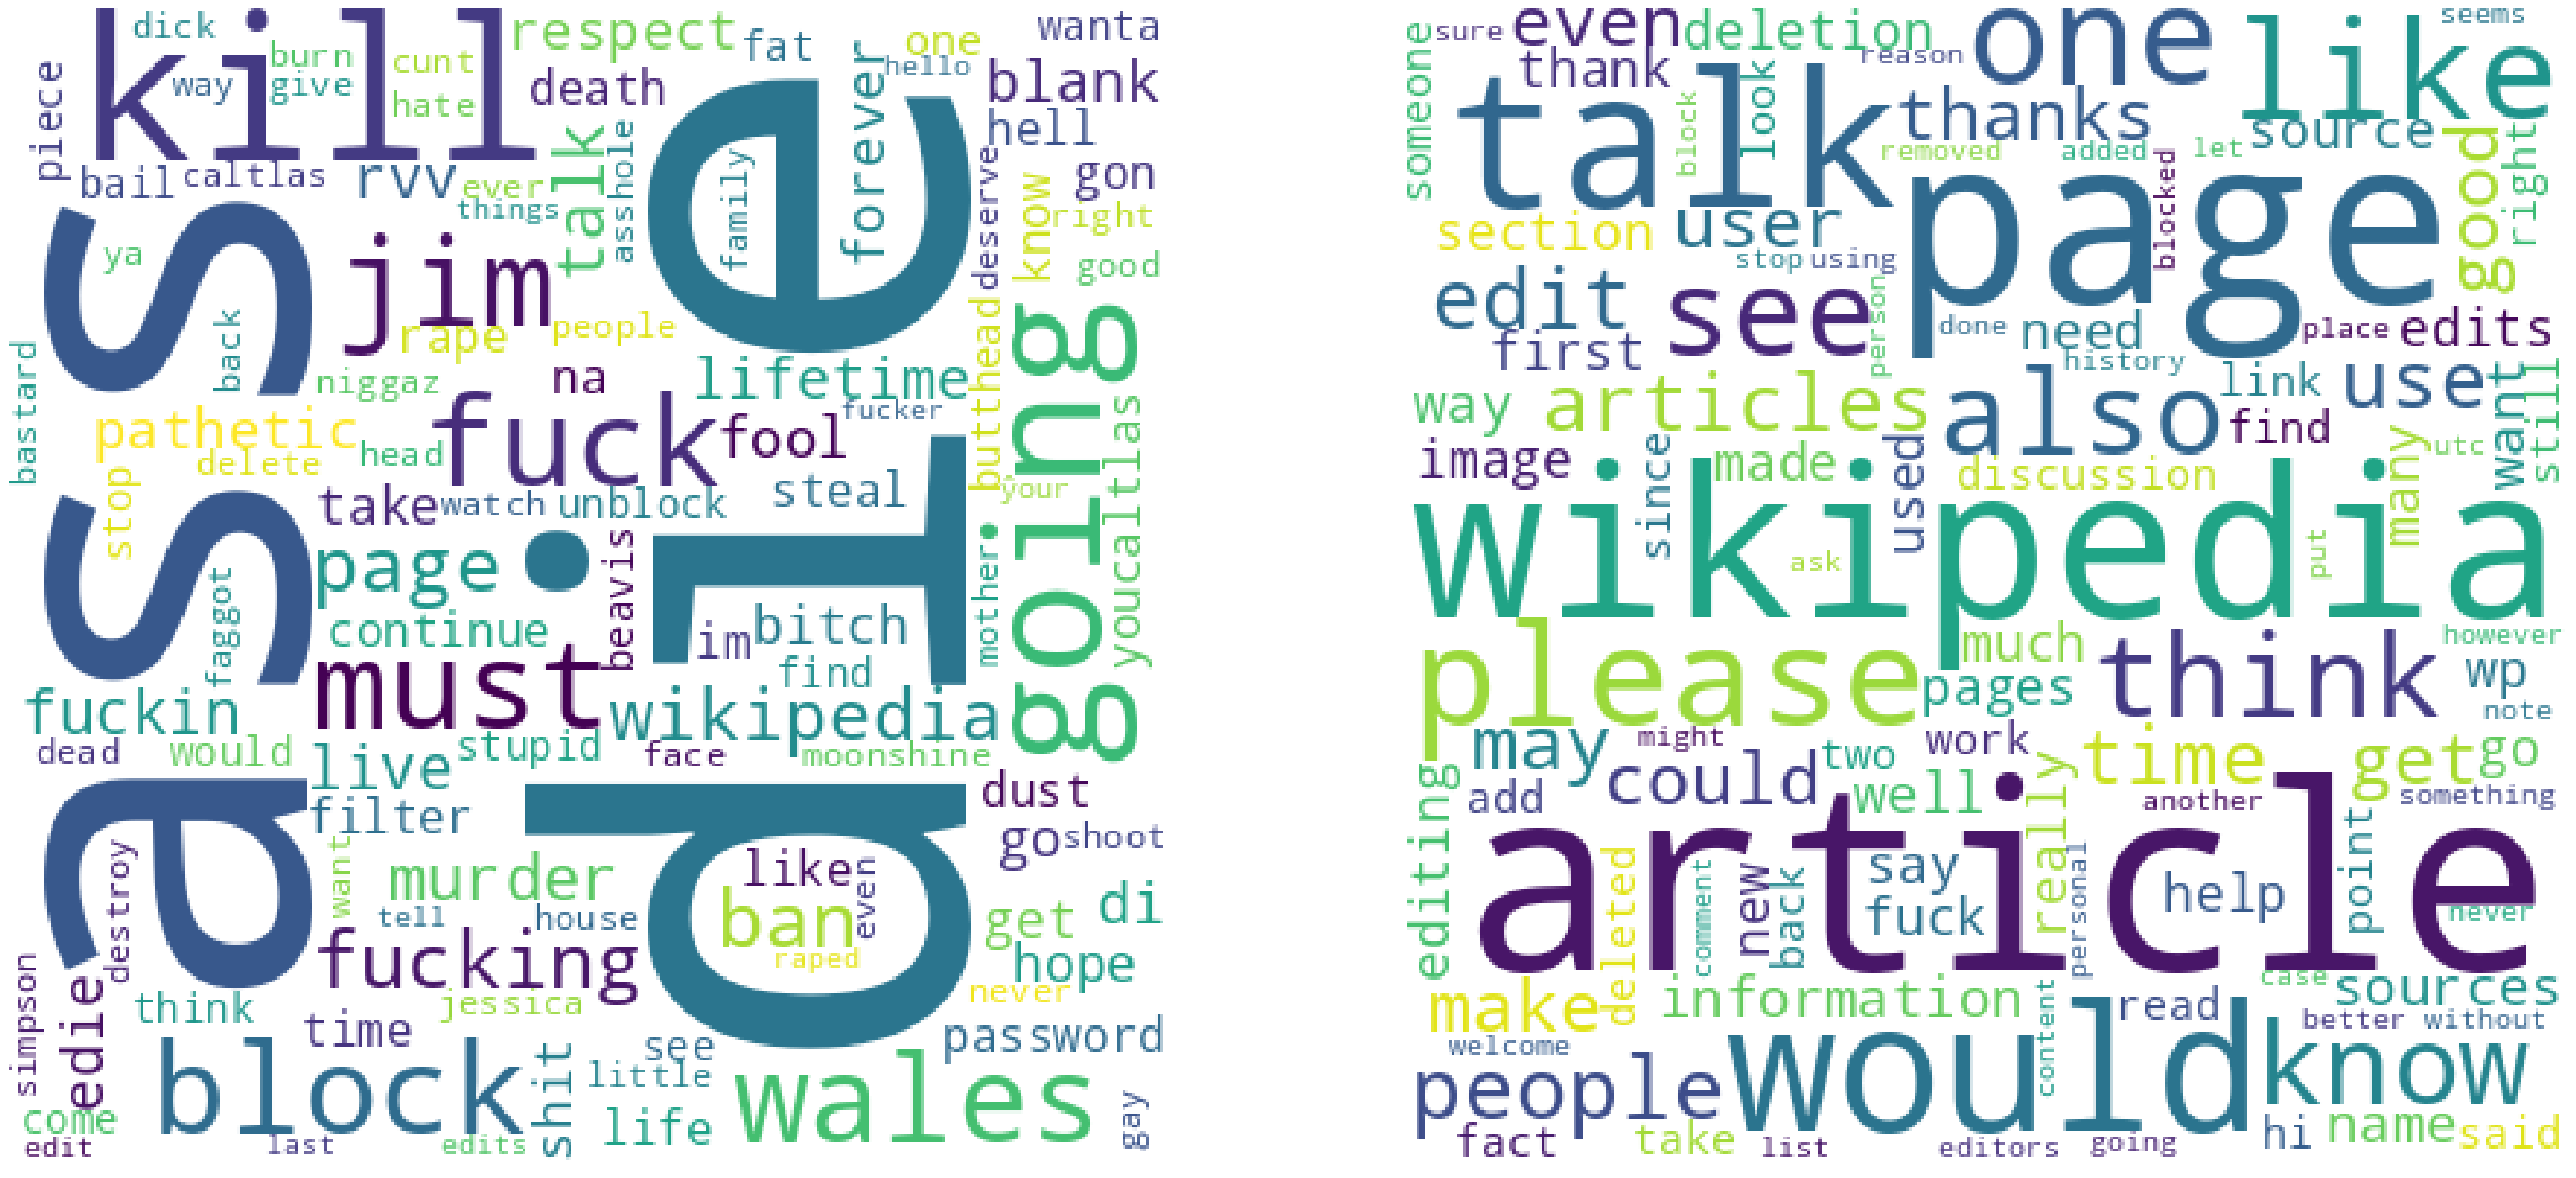

In [16]:
plot_word_cloud(FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["threat"]==1]["cleaned_text"]))),
               FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["threat"]==0]["cleaned_text"]))))

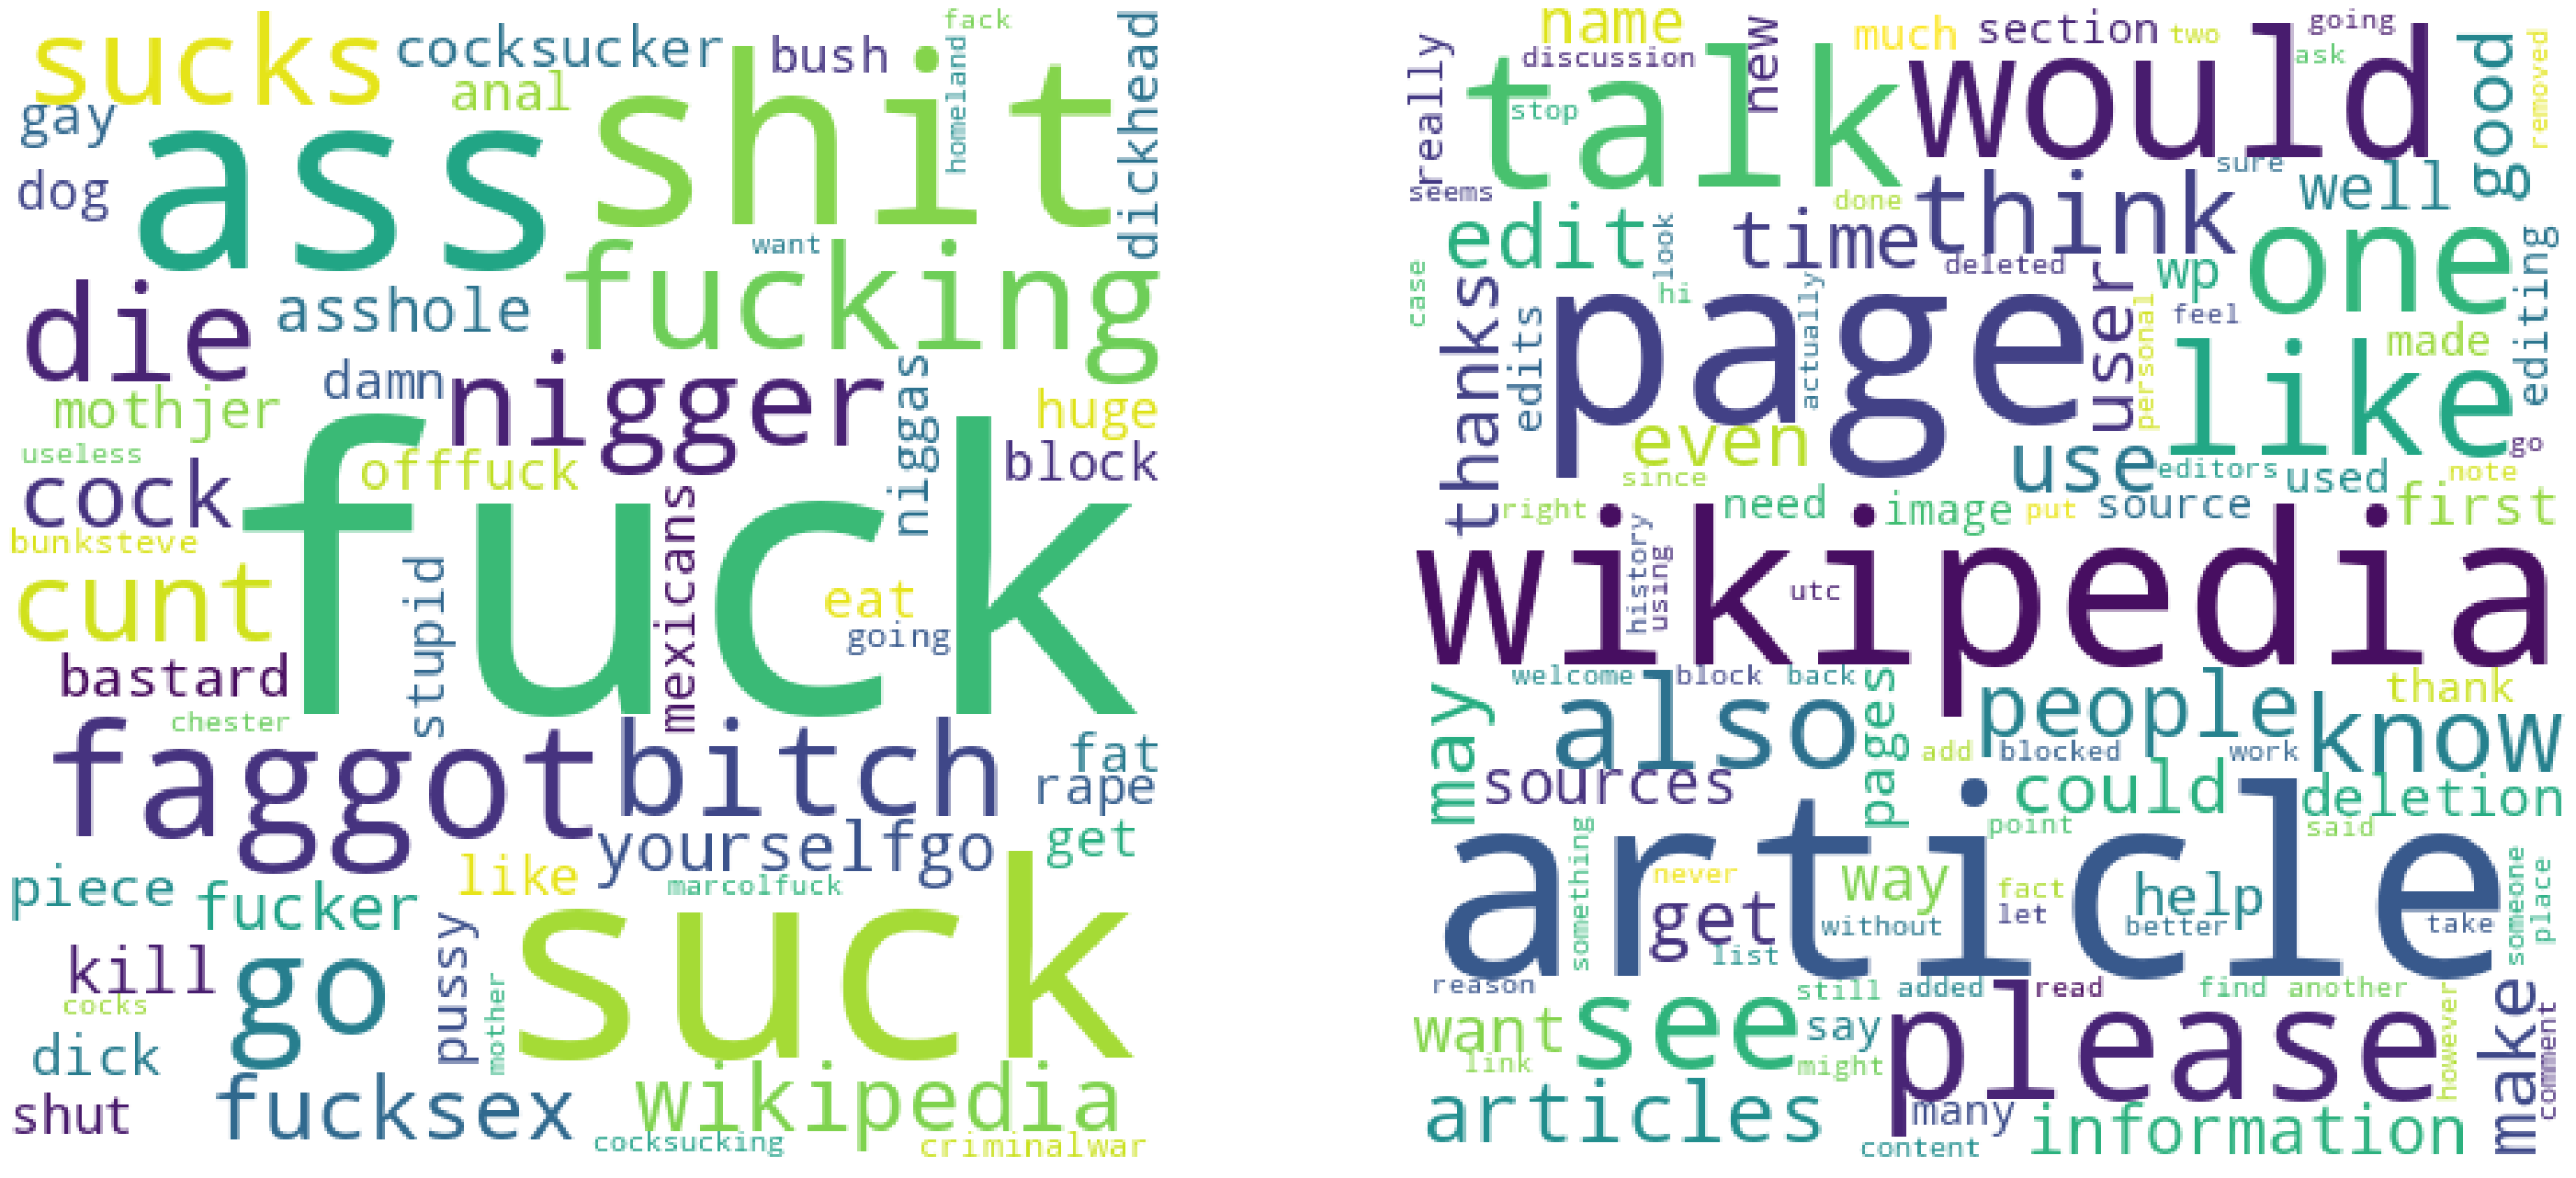

In [17]:
plot_word_cloud(FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["severe_toxic"]==1]["cleaned_text"]))),
               FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["severe_toxic"]==0]["cleaned_text"]))))

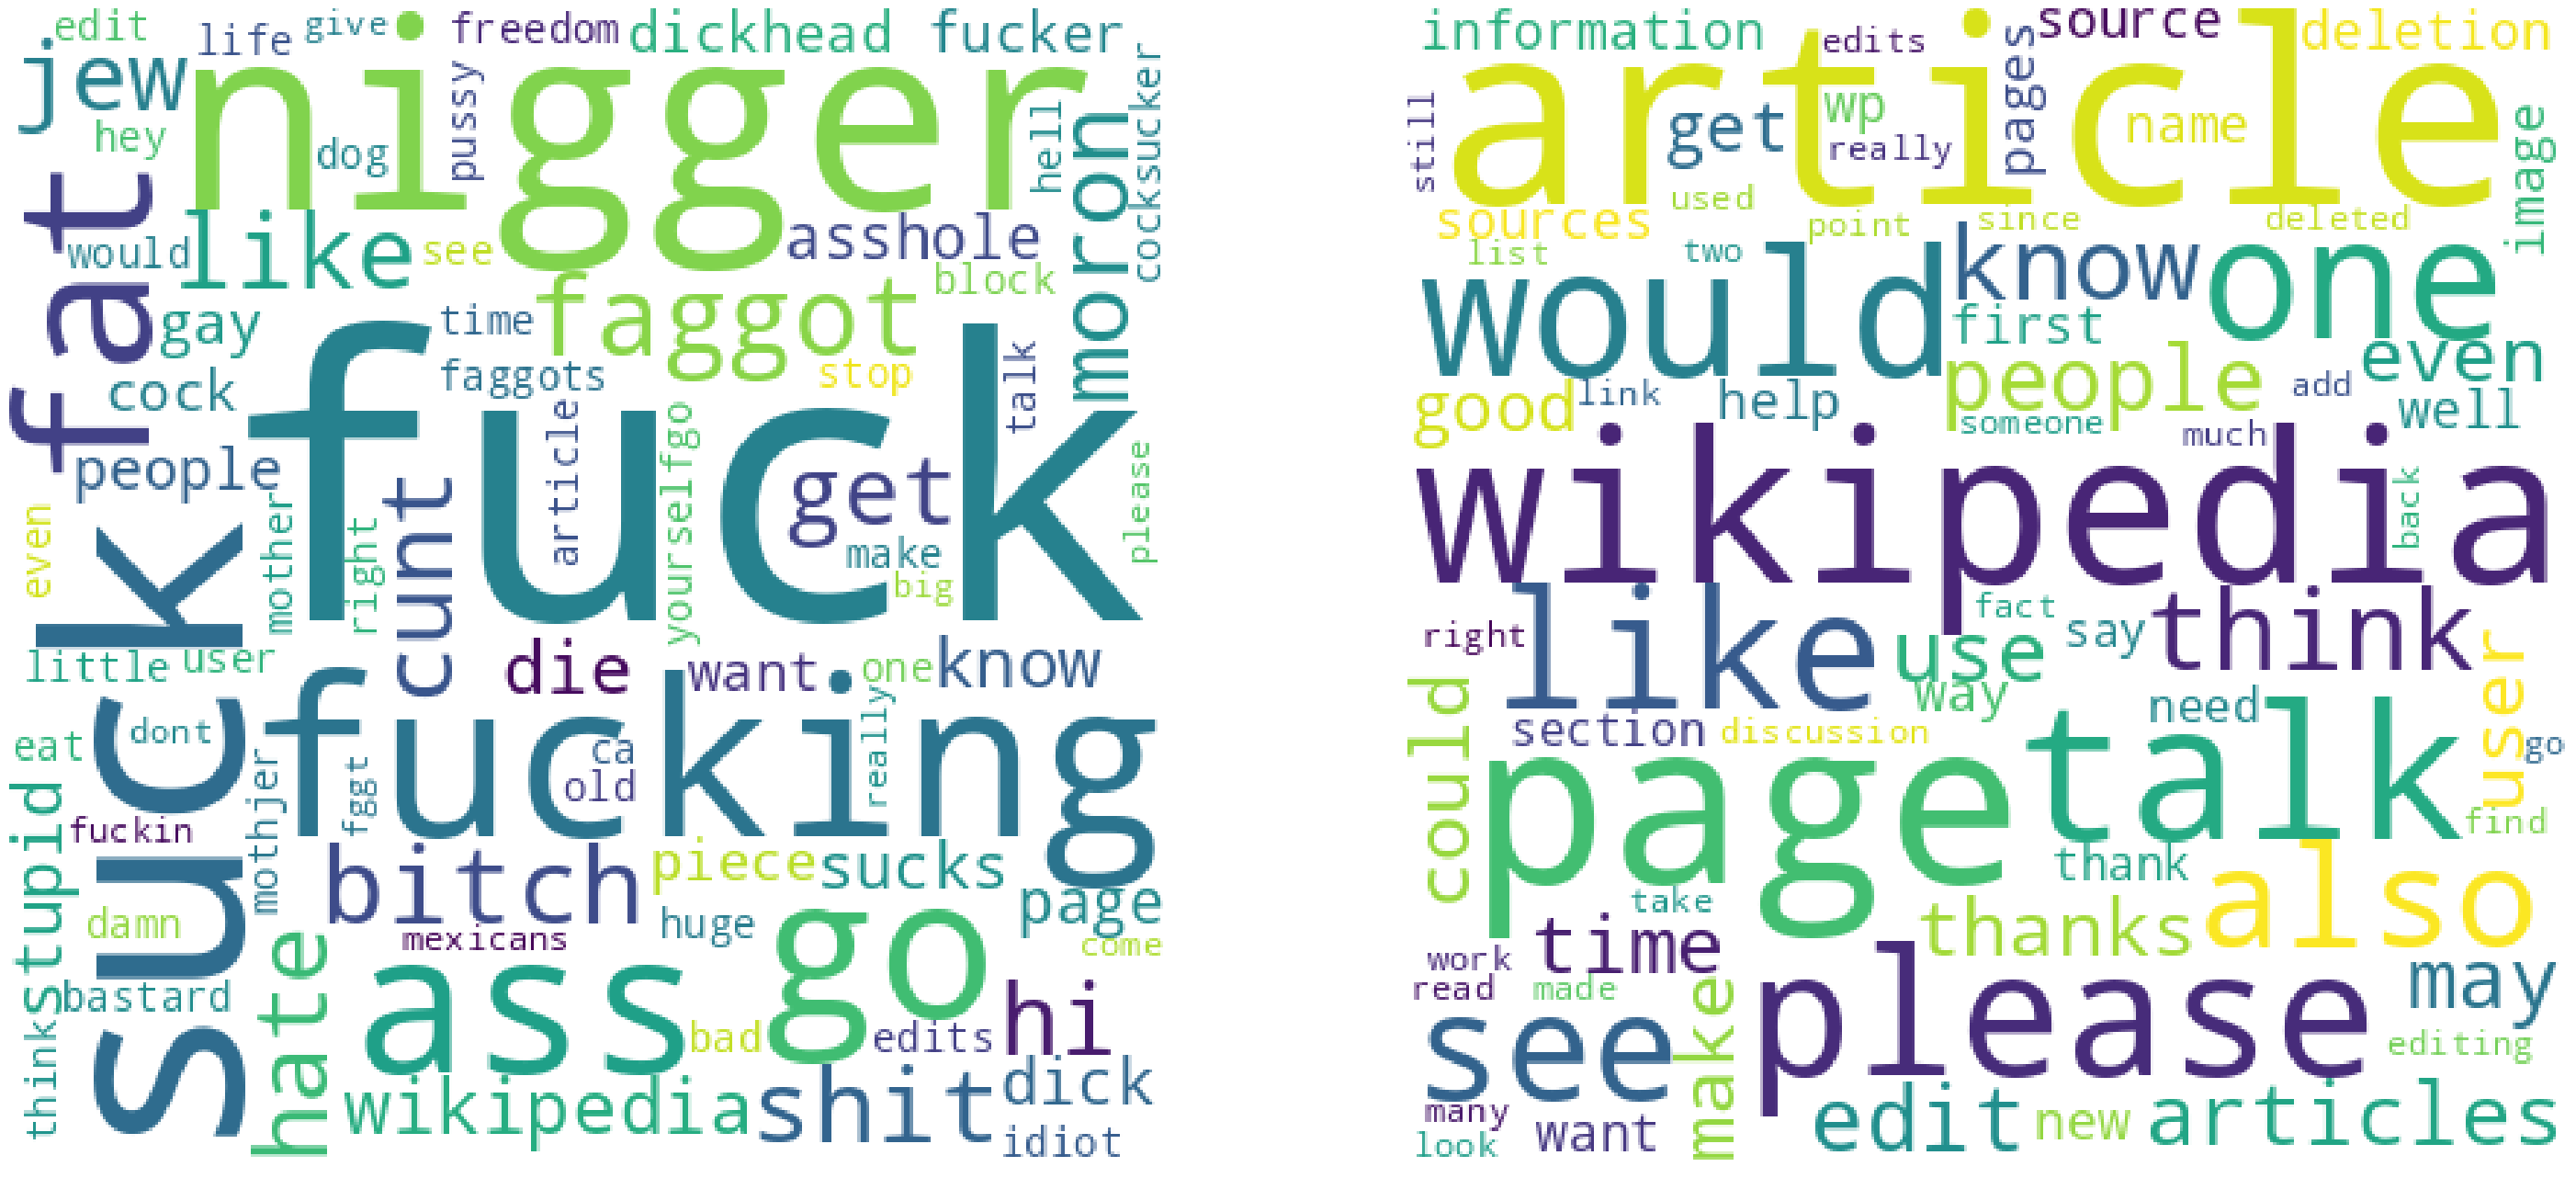

In [18]:
plot_word_cloud(FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["insult"]==1]["cleaned_text"]))),
               FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["insult"]==0]["cleaned_text"]))))

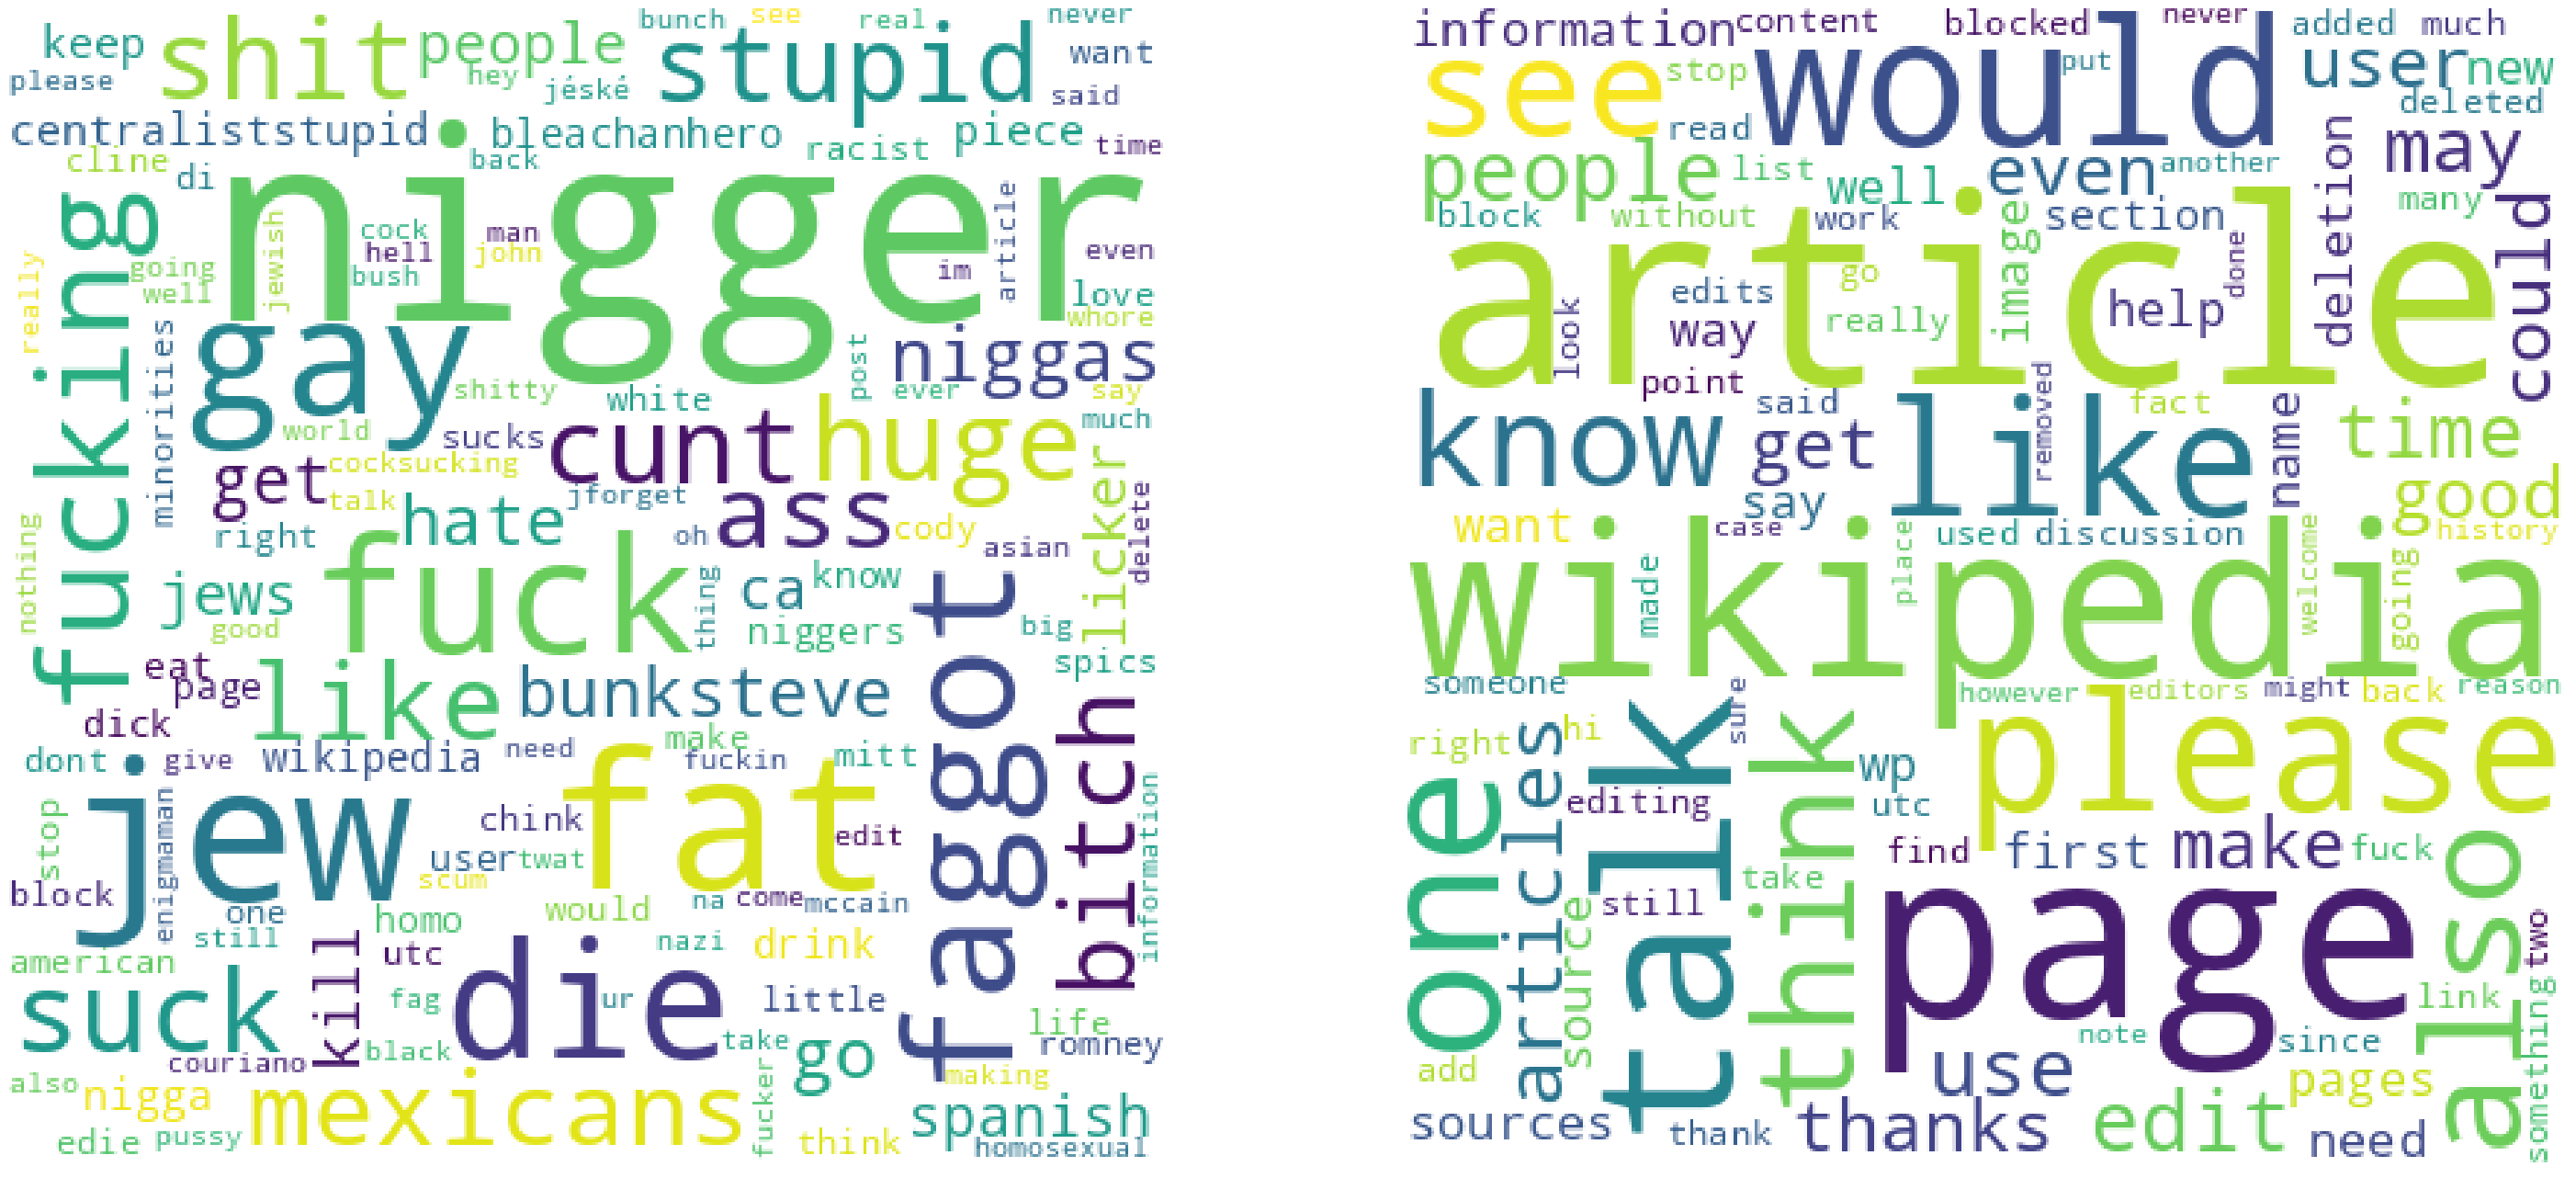

In [19]:
plot_word_cloud(FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["identity_hate"]==1]["cleaned_text"]))),
               FreqDist(nltk.word_tokenize(' '.join(train_df[train_df["identity_hate"]==0]["cleaned_text"]))))

# Extract Features

In [20]:
#TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [' '.join(train_df[train_df["toxic"]==1]["cleaned_text"]),
          ' '.join(train_df[train_df["toxic"]==0]["cleaned_text"]),
          ' '.join(train_df[train_df["severe_toxic"]==1]["cleaned_text"]),
          ' '.join(train_df[train_df["severe_toxic"]==0]["cleaned_text"]),
          ' '.join(train_df[train_df["obscene"]==1]["cleaned_text"]),
          ' '.join(train_df[train_df["obscene"]==0]["cleaned_text"]),
          ' '.join(train_df[train_df["threat"]==1]["cleaned_text"]),
         ' '.join(train_df[train_df["threat"]==0]["cleaned_text"]),
         ' '.join(train_df[train_df["insult"]==1]["cleaned_text"]),
         ' '.join(train_df[train_df["insult"]==0]["cleaned_text"]),
         ' '.join(train_df[train_df["identity_hate"]==1]["cleaned_text"]),
         ' '.join(train_df[train_df["identity_hate"]==0]["cleaned_text"])]
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df

,aa,aaa,aaaa,aaaaa,aaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany,aaaaaaaaaah,aaaaaaaaaahhhhhhhhhhhhhh,aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh,aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh,...,유헌,잡아야,조선인민군,척뉴넘,칠지도,편집,ﬂute,𐌰𐌹,𐌰𐌿,𐌴𐌹
0,0.000216,0.000085,0.000085,0.000185,0.000000,0.000092,0.000072,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000610,0.000075,0.000021,0.000000,0.000012,0.000000,0.000009,0.000012,0.000012,0.000012,...,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000605,0.000081,0.000031,0.000022,0.000011,0.000011,0.000017,0.000011,0.000011,0.000011,...,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011
4,0.000186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000093,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000601,0.000083,0.000031,0.000023,0.000011,0.000011,0.000009,0.000011,0.000011,0.000011,...,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000601,0.000081,0.000030,0.000022,0.000011,0.000011,0.000017,0.000011,0.000011,0.000011,...,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011
8,0.000215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000107,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000599,0.000083,0.000031,0.000023,0.000011,0.000011,0.000009,0.000011,0.000011,0.000011,...,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011


In [21]:
#Unigram
def extract_features(df,test,target_col,clean_col,val):
    #Uigram Frequency distribution for cleaned columns to target column
    #convert text into single string
    txt=' '.join(df[df[target_col]==val][clean_col])
    val_unigram=nltk.FreqDist(nltk.word_tokenize(txt))

   
    #compute unigram feature vector for tweet likelihood to disaster
    df["unigram_"+str(target_col)+"_"+str(val)]=df[clean_col].apply(lambda x: sum([val_unigram.get(wrd) for wrd in nltk.word_tokenize(x) if val_unigram.get(wrd)!=None])/len(val_unigram))
    test["unigram_"+str(target_col)+"_"+str(val)]=test[clean_col].apply(lambda x: sum([val_unigram.get(wrd) for wrd in nltk.word_tokenize(x) if val_unigram.get(wrd)!=None])/len(val_unigram))

    
    return df,test
cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
for c in cols:
    train_df,test_df = extract_features(train_df,test_df,c,"cleaned_text",1)
    train_df,test_df = extract_features(train_df,test_df,c,"cleaned_text",0)
train_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,hashtags,cleaned_text,...,unigram_severe_toxic_1,unigram_severe_toxic_0,unigram_obscene_1,unigram_obscene_0,unigram_threat_1,unigram_threat_0,unigram_insult_1,unigram_insult_0,unigram_identity_hate_1,unigram_identity_hate_0
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,[],explanation edits made username hardcore metal...,...,0.111531,1.071158,0.171417,1.075255,0.106345,1.070594,0.152551,1.076409,0.050037,1.073456
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,[],matches background colour seemingly stuck than...,...,0.051448,0.372218,0.052096,0.375076,0.045061,0.372329,0.039550,0.376147,0.025092,0.373132
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,[],hey man really trying edit war guy constantly ...,...,0.189782,1.085836,0.269649,1.080281,0.122567,1.087722,0.247641,1.082575,0.089068,1.089222


In [22]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'hashtags', 'cleaned_text',
       'unigram_toxic_1', 'unigram_toxic_0', 'unigram_severe_toxic_1',
       'unigram_severe_toxic_0', 'unigram_obscene_1', 'unigram_obscene_0',
       'unigram_threat_1', 'unigram_threat_0', 'unigram_insult_1',
       'unigram_insult_0', 'unigram_identity_hate_1',
       'unigram_identity_hate_0'],
      dtype='object')

# Data Modeling

In [23]:
#Data Labelling Adjustment
cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
#reformate classification classes columns
def labelling_classes(df):
    arr=[]
    for i,val in enumerate(df.iterrows()):
        lbl=[]
        for cls in cols:
            if df.iloc[i][cls]==1:
                lbl.append(cls)
        arr.append(lbl)
    return arr

#define classes 
train_df["classes"]=np.array(labelling_classes(train_df))

train_df.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,hashtags,cleaned_text,...,unigram_severe_toxic_0,unigram_obscene_1,unigram_obscene_0,unigram_threat_1,unigram_threat_0,unigram_insult_1,unigram_insult_0,unigram_identity_hate_1,unigram_identity_hate_0,classes
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,[],explanation edits made username hardcore metal...,...,1.071158,0.171417,1.075255,0.106345,1.070594,0.152551,1.076409,0.050037,1.073456,[]
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,[],matches background colour seemingly stuck than...,...,0.372218,0.052096,0.375076,0.045061,0.372329,0.039550,0.376147,0.025092,0.373132,[]
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,[],hey man really trying edit war guy constantly ...,...,1.085836,0.269649,1.080281,0.122567,1.087722,0.247641,1.082575,0.089068,1.089222,[]


In [24]:
#load training libraries
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score,hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_validate, train_test_split, ShuffleSplit, GridSearchCV, learning_curve
from sklearn.metrics import classification_report

In [25]:
#define variables and target columns
feature_vector = ['unigram_toxic_1','unigram_severe_toxic_1','unigram_obscene_1','unigram_threat_1','unigram_insult_1','unigram_identity_hate_1',
                 'unigram_toxic_0','unigram_severe_toxic_0','unigram_obscene_0','unigram_threat_0','unigram_insult_0','unigram_identity_hate_0']
train_x = train_df[feature_vector]
test_x = test_df[feature_vector]

mlb = MultiLabelBinarizer(classes=('toxic','severe_toxic','obscene','threat','insult','identity_hate'))
y_enc = mlb.fit_transform(train_df["classes"])

# Model Training

In [26]:
#split data for training and testing
#shuffle to apply random shuffle on data splitting
cv = ShuffleSplit( n_splits=5, test_size=0.33)

Gnb = BinaryRelevance(classifier = GaussianNB())
param_values = {'classifier__var_smoothing':[1e-10,1e-9]}  
GS_gnb = GridSearchCV(Gnb, param_grid=param_values, cv=cv)
GS_gnb.fit(train_x,y_enc)
print("best estimator parameters",GS_gnb.best_estimator_)

print("training data evaluation using NB")
y_pred=GS_gnb.best_estimator_.predict(train_x)
loss=hamming_loss(y_enc,y_pred.toarray())
print("hamming loss",loss)
print(classification_report(y_enc,y_pred))

best estimator parameters BinaryRelevance(classifier=GaussianNB(var_smoothing=1e-10),
                require_dense=[True, True])
training data evaluation using NB
hamming loss 0.04184448719796621
              precision    recall  f1-score   support

           0       0.39      0.08      0.13     15294
           1       0.05      0.10      0.07      1595
           2       0.77      0.05      0.09      8449
           3       0.01      0.03      0.01       478
           4       0.64      0.02      0.05      7877
           5       0.18      0.02      0.04      1405

   micro avg       0.22      0.06      0.09     35098
   macro avg       0.34      0.05      0.06     35098
weighted avg       0.51      0.06      0.09     35098
 samples avg       0.01      0.00      0.00     35098



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_clf.fit(train_x, y_enc)
print("training data evaluation using Random forest")
y_pred=rf_clf.predict(train_x)
loss=hamming_loss(y_enc,y_pred)
print("hamming loss",loss)
print(classification_report(y_enc,y_pred))

training data evaluation using Random forest
hamming loss 0.03153455201759718
              precision    recall  f1-score   support

           0       0.99      0.15      0.27     15294
           1       0.00      0.00      0.00      1595
           2       0.98      0.23      0.37      8449
           3       0.00      0.00      0.00       478
           4       0.80      0.12      0.20      7877
           5       0.00      0.00      0.00      1405

   micro avg       0.95      0.15      0.26     35098
   macro avg       0.46      0.08      0.14     35098
weighted avg       0.85      0.15      0.25     35098
 samples avg       0.01      0.01      0.01     35098



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
ada_clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
ada_clf.fit(train_x, y_enc)
print("training data evaluation using Extra Trees")
y_pred=ada_clf.predict(train_x)
loss=hamming_loss(y_enc,y_pred)
print("hamming loss",loss)
print(classification_report(y_enc,y_pred))

training data evaluation using Extra Trees
hamming loss 0.0002506721146072908
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15294
           1       1.00      0.97      0.99      1595
           2       1.00      1.00      1.00      8449
           3       1.00      0.98      0.99       478
           4       1.00      0.99      1.00      7877
           5       1.00      0.99      0.99      1405

   micro avg       1.00      0.99      1.00     35098
   macro avg       1.00      0.99      0.99     35098
weighted avg       1.00      0.99      1.00     35098
 samples avg       0.10      0.10      0.10     35098



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Evaluation

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Random forest classifier
Roc AUC of toxic 0.5773466690061141
Roc AUC of severe 0.5
Roc AUC of obscene 0.6130005988159214
Roc AUC of threat 0.5
Roc AUC of insult 0.5572819791848285
Roc AUC of hate 0.5


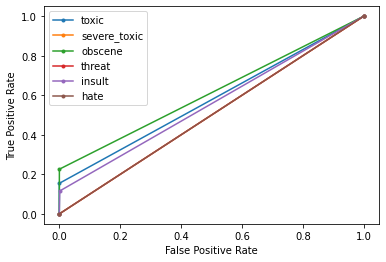

In [30]:
#cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
print("Random forest classifier")
y_pred=rf_clf.predict(train_x)
print("Roc AUC of toxic",roc_auc_score(train_df['toxic'], y_pred[:,0]))
print("Roc AUC of severe",roc_auc_score(train_df['severe_toxic'], y_pred[:,1]))
print("Roc AUC of obscene",roc_auc_score(train_df['obscene'], y_pred[:,2]))
print("Roc AUC of threat",roc_auc_score(train_df['threat'], y_pred[:,3]))
print("Roc AUC of insult",roc_auc_score(train_df['insult'], y_pred[:,4]))
print("Roc AUC of hate",roc_auc_score(train_df['identity_hate'], y_pred[:,5]))
# calculate roc curves
tx_fpr, tx_tpr, _ = roc_curve(train_df['toxic'], y_pred[:,0])
st_fpr, st_tpr, _ = roc_curve(train_df['severe_toxic'], y_pred[:,1])
ob_fpr, ob_tpr, _ = roc_curve(train_df['obscene'], y_pred[:,2])
th_fpr, th_tpr, _ = roc_curve(train_df['threat'], y_pred[:,3])
in_fpr, in_tpr, _ = roc_curve(train_df['insult'], y_pred[:,4])
ha_fpr, ha_tpr, _ = roc_curve(train_df['identity_hate'], y_pred[:,5])
plt.plot(tx_fpr, tx_tpr, marker='.', label='toxic')
plt.plot(st_fpr, st_tpr, marker='.', label='severe_toxic')
plt.plot(ob_fpr, ob_tpr, marker='.', label='obscene')
plt.plot(th_fpr, th_tpr, marker='.', label='threat')
plt.plot(in_fpr, in_tpr, marker='.', label='insult')
plt.plot(ha_fpr, ha_tpr, marker='.', label='hate')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Extra trees classifier
Roc AUC of toxic 0.998471883387134
Roc AUC of severe 0.9871378403100156
Roc AUC of obscene 0.9976754916347198
Roc AUC of threat 0.9905794884269028
Roc AUC of insult 0.9956638592463575
Roc AUC of hate 0.9957232148952204


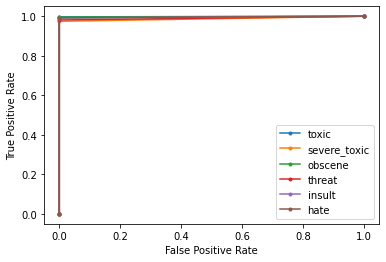

In [31]:
#cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
print("Extra trees classifier")
y_pred=ada_clf.predict(train_x)
print("Roc AUC of toxic",roc_auc_score(train_df['toxic'], y_pred[:,0]))
print("Roc AUC of severe",roc_auc_score(train_df['severe_toxic'], y_pred[:,1]))
print("Roc AUC of obscene",roc_auc_score(train_df['obscene'], y_pred[:,2]))
print("Roc AUC of threat",roc_auc_score(train_df['threat'], y_pred[:,3]))
print("Roc AUC of insult",roc_auc_score(train_df['insult'], y_pred[:,4]))
print("Roc AUC of hate",roc_auc_score(train_df['identity_hate'], y_pred[:,5]))
# calculate roc curves
tx_fpr, tx_tpr, _ = roc_curve(train_df['toxic'], y_pred[:,0])
st_fpr, st_tpr, _ = roc_curve(train_df['severe_toxic'], y_pred[:,1])
ob_fpr, ob_tpr, _ = roc_curve(train_df['obscene'], y_pred[:,2])
th_fpr, th_tpr, _ = roc_curve(train_df['threat'], y_pred[:,3])
in_fpr, in_tpr, _ = roc_curve(train_df['insult'], y_pred[:,4])
ha_fpr, ha_tpr, _ = roc_curve(train_df['identity_hate'], y_pred[:,5])
plt.plot(tx_fpr, tx_tpr, marker='.', label='toxic')
plt.plot(st_fpr, st_tpr, marker='.', label='severe_toxic')
plt.plot(ob_fpr, ob_tpr, marker='.', label='obscene')
plt.plot(th_fpr, th_tpr, marker='.', label='threat')
plt.plot(in_fpr, in_tpr, marker='.', label='insult')
plt.plot(ha_fpr, ha_tpr, marker='.', label='hate')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Model Testing

In [32]:
sub = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')
test_lbl  = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv')
test_lbl

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [33]:
y_pred=rf_clf.predict(test_x)
test_lbl["classes"]=np.array(labelling_classes(test_lbl))
y_enc = mlb.fit_transform(test_lbl["classes"])
loss=hamming_loss(y_enc,y_pred)
print("hamming loss",loss)
print(classification_report(y_enc,y_pred))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


hamming loss 0.023487895327883836
              precision    recall  f1-score   support

           0       0.19      0.15      0.17      6090
           1       0.00      0.00      0.00       367
           2       0.18      0.19      0.18      3691
           3       0.00      0.00      0.00       211
           4       0.14      0.10      0.11      3427
           5       0.00      0.00      0.00       712

   micro avg       0.18      0.13      0.15     14498
   macro avg       0.08      0.07      0.08     14498
weighted avg       0.16      0.13      0.14     14498
 samples avg       0.01      0.00      0.00     14498



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
y_pred=ada_clf.predict(test_x)
test_lbl["classes"]=np.array(labelling_classes(test_lbl))
y_enc = mlb.fit_transform(test_lbl["classes"])
loss=hamming_loss(y_enc,y_pred)
print("hamming loss",loss)
print(classification_report(y_enc,y_pred))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


hamming loss 0.055306730041001805
              precision    recall  f1-score   support

           0       0.16      0.59      0.25      6090
           1       0.08      0.28      0.12       367
           2       0.15      0.60      0.24      3691
           3       0.10      0.07      0.08       211
           4       0.14      0.46      0.21      3427
           5       0.14      0.14      0.14       712

   micro avg       0.15      0.52      0.23     14498
   macro avg       0.13      0.36      0.17     14498
weighted avg       0.15      0.52      0.23     14498
 samples avg       0.02      0.02      0.02     14498



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
